<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/biotech_patent_reduction_hit.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 110.1 MB/s eta 0:00:00


In [3]:
import os 
import json 
# from transformers import AutoTokenizer, BioGptModel
import torch
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
import joblib
import scann

In [4]:
biotech_title_gpt = np.load('drive/MyDrive/transfer/patent/biotech_title_vectors.npy')
biotech_abst_gpt = np.load('drive/MyDrive/transfer/patent/biotech_abstract_vectors.npy')



In [5]:
def normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    


def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr 

In [6]:
def pca_reducer(target_dimension, content, title, title_name):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save('./patent_abst_vectors_norm'+pca_name+title_name,content_vectors_pca)
    np.save('./patent_title_vectors_norm'+pca_name+title_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title,title_name):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(normalizer,1,svd_.transform(title))

    inverse_content = svd_.inverse_transform(content_vectors_svd)
    inverse_title = svd_.inverse_transform(title_vectors_svd)

    np.save('./patent_abst_vectors_norm'+svd_name+title_name,content_vectors_svd)
    np.save('./patent_title_vectors_norm'+svd_name+title_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)
     


In [7]:
pca_reducer(40, biotech_abst_gpt, biotech_title_gpt,'_gpt')
svd_reducer(40, biotech_abst_gpt, biotech_title_gpt,'_gpt')

pca_reducer(57, biotech_abst_gpt, biotech_title_gpt,'_gpt')
svd_reducer(57, biotech_abst_gpt, biotech_title_gpt,'_gpt')

pca_reducer(90, biotech_abst_gpt, biotech_title_gpt,'_gpt')
svd_reducer(90, biotech_abst_gpt, biotech_title_gpt,'_gpt')

pca_reducer(107, biotech_abst_gpt, biotech_title_gpt,'_gpt')
svd_reducer(107, biotech_abst_gpt, biotech_title_gpt,'_gpt')

In [8]:
abstract_pca_40_gpt = np.load('./patent_abst_vectors_norm_pca_40_gpt.npy')
abstract_pca_57_gpt = np.load('./patent_abst_vectors_norm_pca_57_gpt.npy')
abstract_pca_90_gpt = np.load('./patent_abst_vectors_norm_pca_90_gpt.npy')
abstract_pca_107_gpt = np.load('./patent_abst_vectors_norm_pca_107_gpt.npy')

abstract_svd_40_gpt = np.load('./patent_abst_vectors_norm_svd_40_gpt.npy')
abstract_svd_57_gpt = np.load('./patent_abst_vectors_norm_svd_57_gpt.npy')
abstract_svd_90_gpt = np.load('./patent_abst_vectors_norm_svd_90_gpt.npy')
abstract_svd_107_gpt = np.load('./patent_abst_vectors_norm_svd_107_gpt.npy')

title_pca_40_gpt = np.load('./patent_title_vectors_norm_pca_40_gpt.npy')
title_pca_57_gpt = np.load('./patent_title_vectors_norm_pca_57_gpt.npy')
title_pca_90_gpt = np.load('./patent_title_vectors_norm_pca_90_gpt.npy')
title_pca_107_gpt = np.load('./patent_title_vectors_norm_pca_107_gpt.npy')

title_svd_40_gpt = np.load('./patent_title_vectors_norm_svd_40_gpt.npy')
title_svd_57_gpt = np.load('./patent_title_vectors_norm_svd_57_gpt.npy')
title_svd_90_gpt = np.load('./patent_title_vectors_norm_svd_90_gpt.npy')
title_svd_107_gpt = np.load('./patent_title_vectors_norm_svd_107_gpt.npy')

In [9]:
print('content_pca_57_gpt shape:',np.array(abstract_pca_57_gpt).shape)
print('content_pca_90_gpt shape:',np.array(abstract_pca_90_gpt).shape)
print('title_pca_107_gpt shape:',np.array(abstract_pca_107_gpt).shape)
print('title_svd_57_gpt shape:',np.array(abstract_svd_57_gpt).shape)
print('title_svd_90_gpt shape:',np.array(abstract_svd_90_gpt).shape)
print('title_svd_107_gpt shape:',np.array(abstract_svd_107_gpt).shape)


content_pca_57_gpt shape: (484, 57)
content_pca_90_gpt shape: (484, 90)
title_pca_107_gpt shape: (484, 107)
title_svd_57_gpt shape: (484, 57)
title_svd_90_gpt shape: (484, 90)
title_svd_107_gpt shape: (484, 107)


In [10]:
searcher_raw_gpt = scann.scann_ops_pybind.builder(biotech_abst_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_57_gpt = scann.scann_ops_pybind.builder(abstract_pca_57_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_90_gpt = scann.scann_ops_pybind.builder(abstract_pca_90_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107_gpt = scann.scann_ops_pybind.builder(abstract_pca_107_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    


searcher_svd_57_gpt = scann.scann_ops_pybind.builder(abstract_svd_57_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_90_gpt = scann.scann_ops_pybind.builder(abstract_svd_90_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
     
searcher_svd_107_gpt = scann.scann_ops_pybind.builder(abstract_svd_107_gpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()   

In [11]:
raw_idx_gpt = []
# reduced_idx_pca_40 = []
# reduced_idx_svd_40 = []
reduced_idx_pca_57_gpt = []
reduced_idx_svd_57_gpt = []
reduced_idx_pca_90_gpt = []
reduced_idx_svd_90_gpt = []
reduced_idx_pca_107_gpt = []
reduced_idx_svd_107_gpt = []
for i in range(len(biotech_title_gpt)):
    raw_idx_gpt.append(searcher_raw_gpt.search(biotech_title_gpt[i])[0])
    # reduced_idx_pca_40.append(searcher_pca_40.search(title_pca_40[i])[0])
    # reduced_idx_svd_40.append(searcher_svd_40.search(title_svd_40[i])[0])
    reduced_idx_pca_57_gpt.append(searcher_pca_57_gpt.search(title_pca_57_gpt[i])[0])
    reduced_idx_svd_57_gpt.append(searcher_svd_57_gpt.search(title_svd_57_gpt[i])[0])
    reduced_idx_pca_90_gpt.append(searcher_pca_90_gpt.search(title_pca_90_gpt[i])[0])
    reduced_idx_svd_90_gpt.append(searcher_svd_90_gpt.search(title_svd_90_gpt[i])[0])
    reduced_idx_pca_107_gpt.append(searcher_pca_107_gpt.search(title_pca_107_gpt[i])[0])
    reduced_idx_svd_107_gpt.append(searcher_svd_107_gpt.search(title_svd_107_gpt[i])[0])
     


In [12]:


k = [1,3,5,10,15,20,30]
# ap_pca_40, hit_pca_40, mrr_pca_40 = metrics_calculator(raw_idx_gpt,reduced_idx_pca_40_gpt, k )
# ap_svd_40, hit_svd_40, mrr_svd_40 = metrics_calculator(raw_idx_gpt,reduced_idx_svd_40_gpt, k )

ap_pca_57_gpt, hit_pca_57_gpt, mrr_pca_57_gpt = metrics_calculator(raw_idx_gpt,reduced_idx_pca_57_gpt, k )
ap_svd_57_gpt, hit_svd_57_gpt, mrr_svd_57_gpt = metrics_calculator(raw_idx_gpt,reduced_idx_svd_57_gpt, k )

ap_pca_90_gpt, hit_pca_90_gpt, mrr_pca_90_gpt = metrics_calculator(raw_idx_gpt,reduced_idx_pca_90_gpt, k )
ap_svd_90_gpt, hit_svd_90_gpt, mrr_svd_90_gpt = metrics_calculator(raw_idx_gpt,reduced_idx_svd_90_gpt, k )

ap_pca_107_gpt, hit_pca_107_gpt, mrr_pca_107_gpt = metrics_calculator(raw_idx_gpt,reduced_idx_pca_107_gpt, k )
ap_svd_107_gpt, hit_svd_107_gpt, mrr_svd_107_gpt = metrics_calculator(raw_idx_gpt,reduced_idx_svd_107_gpt, k )     
     


<ipython-input-5-2aec6be5bae6>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


[243, 902, 1566, 3223, 4883, 6412, 10218]
[304, 1071, 1889, 3813, 5731, 7705, 11793]
[339, 1136, 1957, 3981, 6123, 8205, 12443]


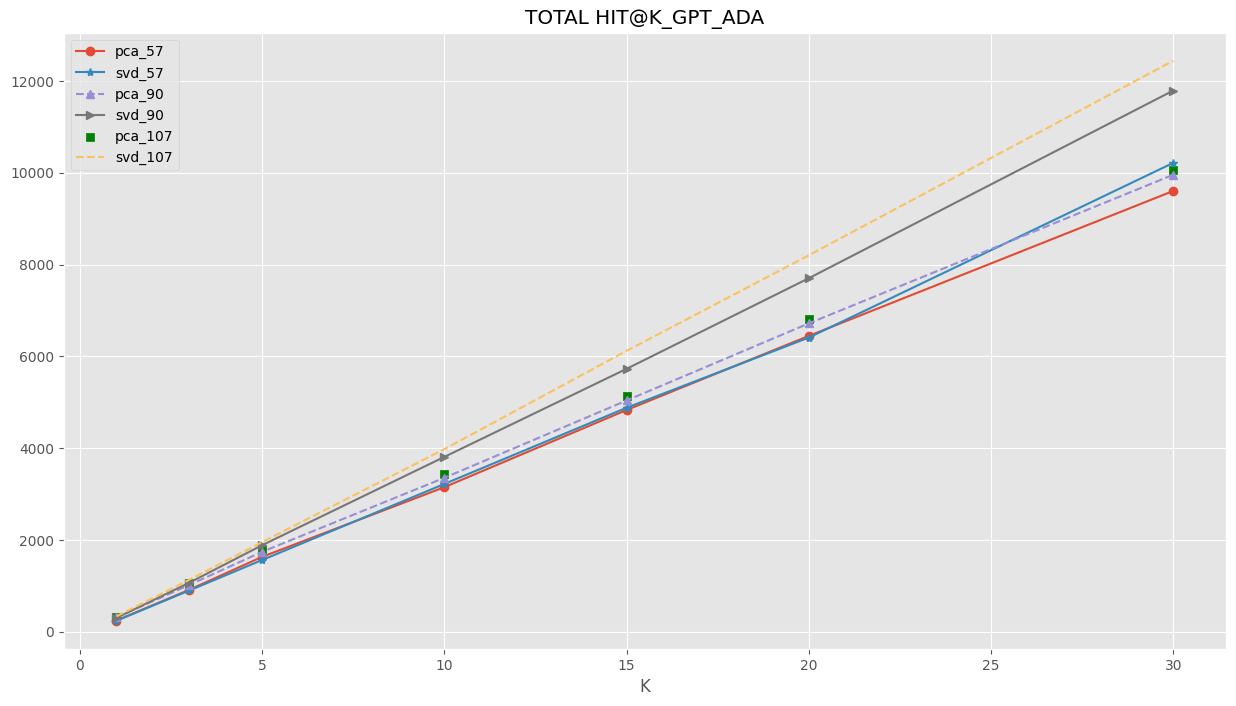

In [13]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
# plt.plot(k,hit_pca_40, '-p', color = 'purple')
# plt.plot(k,hit_svd_40, '-.')
plt.plot(k,hit_pca_57_gpt, '-o')
plt.plot(k,hit_svd_57_gpt, '-*')
plt.plot(k,hit_pca_90_gpt, '--^')
plt.plot(k,hit_svd_90_gpt, '>-')
plt.scatter(k,hit_pca_107_gpt, marker ='s',color= 'green')
plt.plot(k,hit_svd_107_gpt, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K_GPT_ADA')
plt.legend(['pca_57','svd_57','pca_90','svd_90','pca_107','svd_107'])
plt.xlabel('K');

print(hit_svd_57_gpt)
print(hit_svd_90_gpt)
print(hit_svd_107_gpt)

## biogpt

In [14]:
abst_vectors_biogpt = np.load('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt.npy')
abst_vectors_norm_biogpt = np.load('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt_norm.npy')

title_vectors_biogpt = np.load('drive/MyDrive/transfer/patent/data_biotech_title_biogpt.npy')
title_vectors_norm_biogpt = np.load('drive/MyDrive/transfer/patent/data_biotech_title_biogpt_norm.npy')

In [15]:
pca_reducer(57, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')
svd_reducer(57, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')

pca_reducer(86, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')
svd_reducer(86, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')

pca_reducer(154, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')
svd_reducer(154, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')

pca_reducer(107, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')
svd_reducer(107, abst_vectors_norm_biogpt, title_vectors_norm_biogpt,'_biogpt')

In [16]:
abstract_pca_57_biogpt = np.load('./patent_abst_vectors_norm_pca_57_biogpt.npy')
abstract_pca_86_biogpt = np.load('./patent_abst_vectors_norm_pca_86_biogpt.npy')
abstract_pca_154_biogpt = np.load('./patent_abst_vectors_norm_pca_154_biogpt.npy')
abstract_pca_107_biogpt = np.load('./patent_abst_vectors_norm_pca_107_biogpt.npy')
abstract_svd_57_biogpt = np.load('./patent_abst_vectors_norm_svd_57_biogpt.npy')
abstract_svd_86_biogpt = np.load('./patent_abst_vectors_norm_svd_86_biogpt.npy')
abstract_svd_107_biogpt = np.load('./patent_abst_vectors_norm_svd_107_biogpt.npy')
abstract_svd_154_biogpt = np.load('./patent_abst_vectors_norm_svd_154_biogpt.npy')

title_pca_57_biogpt = np.load('./patent_title_vectors_norm_pca_57_biogpt.npy')
title_pca_86_biogpt = np.load('./patent_title_vectors_norm_pca_86_biogpt.npy')
title_pca_107_biogpt = np.load('./patent_title_vectors_norm_pca_107_biogpt.npy')
title_pca_154_biogpt = np.load('./patent_title_vectors_norm_pca_154_biogpt.npy')
title_svd_57_biogpt = np.load('./patent_title_vectors_norm_svd_57_biogpt.npy')
title_svd_86_biogpt = np.load('./patent_title_vectors_norm_svd_86_biogpt.npy')
title_svd_107_biogpt = np.load('./patent_title_vectors_norm_svd_107_biogpt.npy')
title_svd_154_biogpt = np.load('./patent_title_vectors_norm_svd_154_biogpt.npy')

In [17]:
searcher_raw_biogpt = scann.scann_ops_pybind.builder(abst_vectors_norm_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_57_biogpt = scann.scann_ops_pybind.builder(abstract_pca_57_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_86_biogpt = scann.scann_ops_pybind.builder(abstract_pca_86_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107_biogpt = scann.scann_ops_pybind.builder(abstract_pca_107_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    


searcher_svd_57_biogpt = scann.scann_ops_pybind.builder(abstract_svd_57_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_86_biogpt = scann.scann_ops_pybind.builder(abstract_svd_86_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
     
searcher_svd_107_biogpt = scann.scann_ops_pybind.builder(abstract_svd_107_biogpt, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

In [18]:
abstract_pca_86_biogpt.shape

(484, 86)

In [19]:
raw_idx_biogpt = []
# reduced_idx_pca_40 = []
# reduced_idx_svd_40 = []
reduced_idx_pca_57_biogpt = []
reduced_idx_svd_57_biogpt = []
reduced_idx_pca_86_biogpt = []
reduced_idx_svd_86_biogpt = []
reduced_idx_pca_107_biogpt = []
reduced_idx_svd_107_biogpt = []
for i in range(len(biotech_title_gpt)):
    raw_idx_biogpt.append(searcher_raw_biogpt.search(title_vectors_norm_biogpt[i])[0])
    # reduced_idx_pca_40.append(searcher_pca_40.search(title_pca_40[i])[0])
    # reduced_idx_svd_40.append(searcher_svd_40.search(title_svd_40[i])[0])
    reduced_idx_pca_57_biogpt.append(searcher_pca_57_biogpt.search(title_pca_57_biogpt[i])[0])
    reduced_idx_svd_57_biogpt.append(searcher_svd_57_biogpt.search(title_svd_57_biogpt[i])[0])
    reduced_idx_pca_86_biogpt.append(searcher_pca_86_biogpt.search(title_pca_86_biogpt[i])[0])
    reduced_idx_svd_86_biogpt.append(searcher_svd_86_biogpt.search(title_svd_86_biogpt[i])[0])
    reduced_idx_pca_107_biogpt.append(searcher_pca_107_biogpt.search(title_pca_107_biogpt[i])[0])
    reduced_idx_svd_107_biogpt.append(searcher_svd_107_biogpt.search(title_svd_107_biogpt[i])[0])

In [20]:
k = [1,3,5,10,15,20,30]
# ap_pca_40, hit_pca_40, mrr_pca_40 = metrics_calculator(raw_idx_gpt,reduced_idx_pca_40_gpt, k )
# ap_svd_40, hit_svd_40, mrr_svd_40 = metrics_calculator(raw_idx_gpt,reduced_idx_svd_40_gpt, k )

ap_pca_57_biogpt, hit_pca_57_biogpt, mrr_pca_57_biogpt = metrics_calculator(raw_idx_biogpt,reduced_idx_pca_57_biogpt, k )
ap_svd_57_biogpt, hit_svd_57_biogpt, mrr_svd_57_biogpt = metrics_calculator(raw_idx_biogpt,reduced_idx_svd_57_biogpt, k )

ap_pca_86_biogpt, hit_pca_86_biogpt, mrr_pca_86_biogpt= metrics_calculator(raw_idx_biogpt,reduced_idx_pca_86_biogpt, k )
ap_svd_86_biogpt, hit_svd_86_biogpt, mrr_svd_86_biogpt = metrics_calculator(raw_idx_biogpt,reduced_idx_svd_86_biogpt, k )

ap_pca_107_biogpt, hit_pca_107_biogpt, mrr_pca_107_biogpt = metrics_calculator(raw_idx_biogpt,reduced_idx_pca_107_biogpt, k )
ap_svd_107_biogpt, hit_svd_107_biogpt, mrr_svd_107_biogpt = metrics_calculator(raw_idx_biogpt,reduced_idx_svd_107_biogpt, k )    

<ipython-input-5-2aec6be5bae6>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


[427, 1295, 2146, 4343, 6409, 8496, 12635]
[434, 1299, 2135, 4434, 6590, 8846, 13286]
[410, 1273, 2111, 4447, 6732, 9002, 13645]


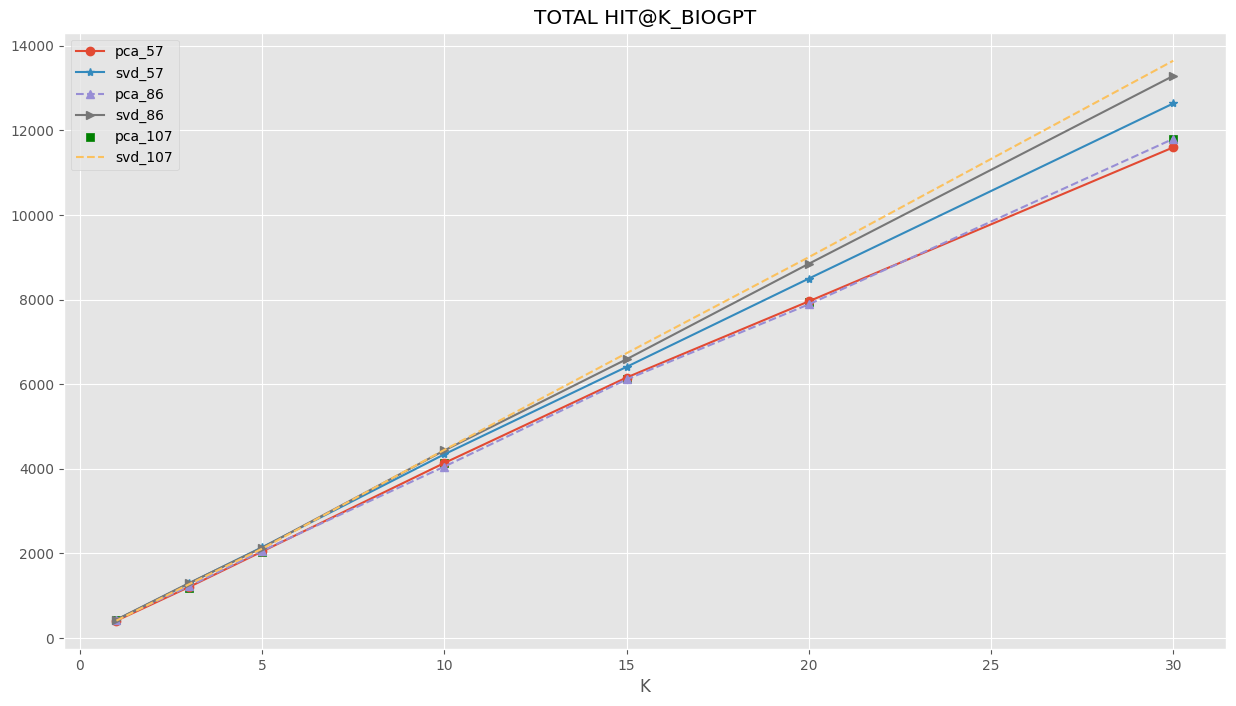

In [21]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
# plt.plot(k,hit_pca_40, '-p', color = 'purple')
# plt.plot(k,hit_svd_40, '-.')
plt.plot(k,hit_pca_57_biogpt, '-o')
plt.plot(k,hit_svd_57_biogpt, '-*')
plt.plot(k,hit_pca_86_biogpt, '--^')
plt.plot(k,hit_svd_86_biogpt, '>-')
plt.scatter(k,hit_pca_107_biogpt, marker ='s',color= 'green')
plt.plot(k,hit_svd_107_biogpt, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K_BIOGPT')
plt.legend(['pca_57','svd_57','pca_86','svd_86','pca_107','svd_107'])
plt.xlabel('K');

print(hit_svd_57_biogpt)
print(hit_svd_86_biogpt)
print(hit_svd_107_biogpt)

## biogpt Large

In [22]:
# abst_vectors_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_biotech_abstract_biogpt_large.npy')
abst_vectors_norm_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_biotech_abstract_biogpt_large_norm.npy')

# title_vectors_biogpt_large = np.load('drive/MyDrive/transfer/patent/data_biotech_title_biogpt.npy')
title_vectors_norm_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_biotech_title_biogpt_large_norm.npy')

In [23]:
print(abst_vectors_norm_biogpt_large.shape)

(484, 1600)


In [24]:
pca_reducer(52, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')
svd_reducer(52, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')

pca_reducer(86, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')
svd_reducer(86, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')

pca_reducer(154, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')
svd_reducer(154, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')

pca_reducer(107, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')
svd_reducer(107, abst_vectors_norm_biogpt_large, title_vectors_norm_biogpt_large,'_biogpt_large')

In [25]:
abstract_pca_52_biogpt_large = np.load('./patent_abst_vectors_norm_pca_52_biogpt_large.npy')
abstract_pca_86_biogpt_large = np.load('./patent_abst_vectors_norm_pca_86_biogpt_large.npy')
abstract_pca_154_biogpt_large = np.load('./patent_abst_vectors_norm_pca_154_biogpt_large.npy')
abstract_pca_107_biogpt_large = np.load('./patent_abst_vectors_norm_pca_107_biogpt_large.npy')
abstract_svd_52_biogpt_large = np.load('./patent_abst_vectors_norm_svd_52_biogpt_large.npy')
abstract_svd_86_biogpt_large = np.load('./patent_abst_vectors_norm_svd_86_biogpt_large.npy')
abstract_svd_107_biogpt_large = np.load('./patent_abst_vectors_norm_svd_107_biogpt_large.npy')
abstract_svd_154_biogpt_large = np.load('./patent_abst_vectors_norm_svd_154_biogpt_large.npy')

title_pca_52_biogpt_large = np.load('./patent_title_vectors_norm_pca_52_biogpt_large.npy')
title_pca_86_biogpt_large = np.load('./patent_title_vectors_norm_pca_86_biogpt_large.npy')
title_pca_107_biogpt_large = np.load('./patent_title_vectors_norm_pca_107_biogpt_large.npy')
title_pca_154_biogpt_large = np.load('./patent_title_vectors_norm_pca_154_biogpt_large.npy')
title_svd_52_biogpt_large = np.load('./patent_title_vectors_norm_svd_52_biogpt_large.npy')
title_svd_86_biogpt_large = np.load('./patent_title_vectors_norm_svd_86_biogpt_large.npy')
title_svd_107_biogpt_large = np.load('./patent_title_vectors_norm_svd_107_biogpt_large.npy')
title_svd_154_biogpt_large = np.load('./patent_title_vectors_norm_svd_154_biogpt_large.npy')

In [26]:
searcher_raw_biogpt_large = scann.scann_ops_pybind.builder(abst_vectors_norm_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_52_biogpt_large = scann.scann_ops_pybind.builder(abstract_pca_52_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_86_biogpt_large = scann.scann_ops_pybind.builder(abstract_pca_86_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107_biogpt_large = scann.scann_ops_pybind.builder(abstract_pca_107_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    


searcher_svd_52_biogpt_large = scann.scann_ops_pybind.builder(abstract_svd_52_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_86_biogpt_large = scann.scann_ops_pybind.builder(abstract_svd_86_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
     
searcher_svd_107_biogpt_large = scann.scann_ops_pybind.builder(abstract_svd_107_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

In [35]:
raw_idx_biogpt_large = []
# reduced_idx_pca_40 = []
# reduced_idx_svd_40 = []
reduced_idx_pca_52_biogpt_large = []
reduced_idx_svd_52_biogpt_large = []
reduced_idx_pca_86_biogpt_large = []
reduced_idx_svd_86_biogpt_large = []
reduced_idx_pca_107_biogpt_large = []
reduced_idx_svd_107_biogpt_large = []
for i in range(len(title_pca_52_biogpt_large)):
    raw_idx_biogpt_large.append(searcher_raw_biogpt_large.search(title_vectors_norm_biogpt_large[i])[0])
    # reduced_idx_pca_40.append(searcher_pca_40.search(title_pca_40[i])[0])
    # reduced_idx_svd_40.append(searcher_svd_40.search(title_svd_40[i])[0])
    reduced_idx_pca_52_biogpt_large.append(searcher_pca_52_biogpt_large.search(title_pca_52_biogpt_large[i])[0])
    reduced_idx_svd_52_biogpt_large.append(searcher_svd_52_biogpt_large.search(title_svd_52_biogpt_large[i])[0])
    reduced_idx_pca_86_biogpt_large.append(searcher_pca_86_biogpt_large.search(title_pca_86_biogpt_large[i])[0])
    reduced_idx_svd_86_biogpt_large.append(searcher_svd_86_biogpt_large.search(title_svd_86_biogpt_large[i])[0])
    reduced_idx_pca_107_biogpt_large.append(searcher_pca_107_biogpt_large.search(title_pca_107_biogpt_large[i])[0])
    reduced_idx_svd_107_biogpt_large.append(searcher_svd_107_biogpt_large.search(title_svd_107_biogpt_large[i])[0])

In [36]:
k = [1,3,5,10,15,20,30]
# ap_pca_40, hit_pca_40, mrr_pca_40 = metrics_calculator(raw_idx_gpt,reduced_idx_pca_40_gpt, k )
# ap_svd_40, hit_svd_40, mrr_svd_40 = metrics_calculator(raw_idx_gpt,reduced_idx_svd_40_gpt, k )

ap_pca_52_biogpt_large, hit_pca_52_biogpt_large, mrr_pca_52_biogpt_large = metrics_calculator(raw_idx_biogpt_large,reduced_idx_pca_52_biogpt_large, k )
ap_svd_52_biogpt_large, hit_svd_52_biogpt_large, mrr_svd_52_biogpt_large = metrics_calculator(raw_idx_biogpt_large,reduced_idx_svd_52_biogpt_large, k )

ap_pca_86_biogpt_large, hit_pca_86_biogpt_large, mrr_pca_86_biogpt_large= metrics_calculator(raw_idx_biogpt_large,reduced_idx_pca_86_biogpt_large, k )
ap_svd_86_biogpt_large, hit_svd_86_biogpt_large, mrr_svd_86_biogpt_large = metrics_calculator(raw_idx_biogpt_large,reduced_idx_svd_86_biogpt_large, k )

ap_pca_107_biogpt_large, hit_pca_107_biogpt_large, mrr_pca_107_biogpt_large = metrics_calculator(raw_idx_biogpt_large,reduced_idx_pca_107_biogpt_large, k )
ap_svd_107_biogpt_large, hit_svd_107_biogpt_large, mrr_svd_107_biogpt_large = metrics_calculator(raw_idx_biogpt_large,reduced_idx_svd_107_biogpt_large, k )    

<ipython-input-5-2aec6be5bae6>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


[375, 1230, 2030, 4187, 6305, 8469, 12899]
[422, 1277, 2116, 4464, 6643, 8932, 13576]
[431, 1336, 2178, 4555, 6790, 9147, 13874]


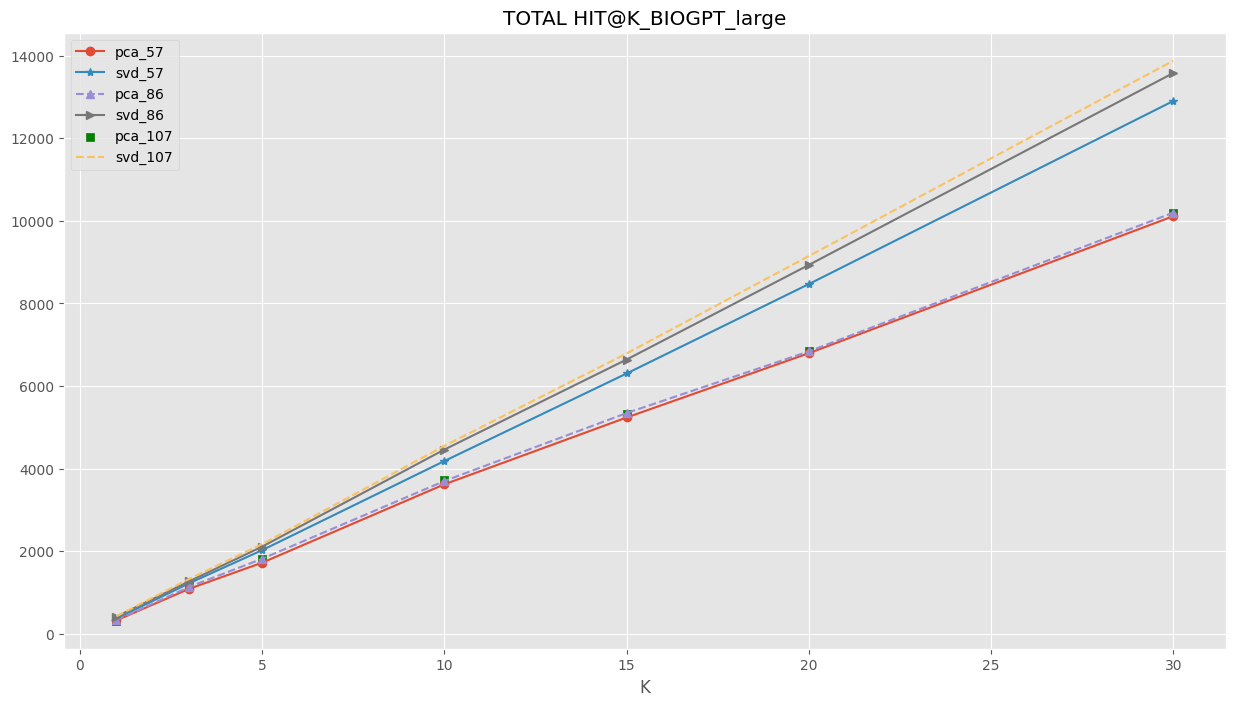

In [37]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
# plt.plot(k,hit_pca_40, '-p', color = 'purple')
# plt.plot(k,hit_svd_40, '-.')
plt.plot(k,hit_pca_52_biogpt_large, '-o')
plt.plot(k,hit_svd_52_biogpt_large, '-*')
plt.plot(k,hit_pca_86_biogpt_large, '--^')
plt.plot(k,hit_svd_86_biogpt_large, '>-')
plt.scatter(k,hit_pca_107_biogpt_large, marker ='s',color= 'green')
plt.plot(k,hit_svd_107_biogpt_large, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K_BIOGPT_large')
plt.legend(['pca_57','svd_57','pca_86','svd_86','pca_107','svd_107'])
plt.xlabel('K');

print(hit_svd_52_biogpt_large)
print(hit_svd_86_biogpt_large)
print(hit_svd_107_biogpt_large)